In [7]:
import sys 
import os
import h5py
import pickle
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import cv2
import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from random import shuffle
from tqdm import tqdm, tnrange, tqdm_notebook
import collections
import random
import mahotas 
from sklearn.preprocessing import normalize
import image
import imutils
import logging

# save and load pickle objects 
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
		
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)		

# create grayscale image from database image
def gray( img ):
	array =  np.dot( np.transpose( img, (1,2,0)), [0.299, 0.587, 0.114] )
	return array.astype(np.uint8)

# find max distance given a list of points 
def find_max( point_list):

	max_dist = 0.000
	first_point = point_list[0]
	second_point = point_list[1]

	for i in range(0, len(point_list)-1):
		for j in range(i+1, len(point_list)):
			
			dist_sq =  (point_list[i][0] - point_list[j][0])**2 + (point_list[i][1] - point_list[j][1])**2 
			
			if dist_sq > max_dist:
				max_dist = dist_sq
				first_point = point_list[i]
				second_point = point_list[j]
				
	return first_point, second_point, math.sqrt(max_dist)
	
# if object is a circle, find max distance which also has the closest slope to the best fit slope 
def find_tiebreaker( x, y, best_slope, max_dist ):

	first_point = (x[0], y[0])
	second_point = (x[1], y[1])
	min_slope_diff = 999999.999
	
	for i in range(0, len(x)-1):
		for j in range(i+1,len(x)+i):
		
			if j >= len(x):
				j = j % len(x)
			
			dist = math.sqrt( (x[i] - x[j])**2 + (y[i] - y[j])**2 )
			if (max_dist - dist)/max_dist <= 0.08 and (x[i] - x[j]) != 0 :
				slope_diff = abs( (y[i] - y[j])/(x[i] - x[j]) - best_slope )
				
				if slope_diff < min_slope_diff:
					min_slope_diff = slope_diff
					first_point = (x[i], y[i])
					second_point = (x[j], y[j])	

	return first_point, second_point
	

# find midpoints between two points given a set of fractions  
def get_midway (p1, p2, fractions):
	
	midpts = []
	dx = p2[0] - p1[0]
	dy = p2[1] - p1[1]
	
	for n, fract in enumerate(fractions):
		x = p1[0] + fract * dx 
		y = p1[1] + fract * dy 
		midpts.append( (x,y) )
			
	return midpts

# find intersection of 2 lines 	
def line_intersect(line1, line2):
	xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
	ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) 
	
	def det(a, b):
		return a[0] * b[1] - a[1] * b[0]
	
	div = det(xdiff, ydiff)
	if div == 0:
		return (-999999,-999999) 

	d = (det(*line1), det(*line2))
	x = det(d, xdiff) / div
	y = det(d, ydiff) / div
	return x, y	
	
# find points of intersection between normal line and all possible line segments in contour 
def find_intersect( x1, y1, x2, y2):
	
	intersect = []
	
	for i in range(0,len(x2)):
		j = i + 1
		if j == len(x2):
			j = 0
		
		# find point of intersection
		point = line_intersect( ((x1[0], y1[0]), (x1[-1], y1[-1])), ((x2[i], y2[i]), (x2[j], y2[j])) )
		
		# check that the point lies on the contour 
		dotproduct = (point[0] - x2[i]) * (x2[j] - x2[i]) + (point[1] - y2[i])*(y2[j] - y2[i])
		squaredlength = (x2[j] - x2[i])**2 + (y2[j] - y2[i])**2
		
		if dotproduct >= 0 and dotproduct <= squaredlength and point not in intersect:
			intersect.append( point )

	return intersect

def ab_random(img, n=1):
	# This function takes an input image (32 by 32) and applies a random aberration to it, either some affine transformation or an occlusion N times.
	# Note that the input image is mutated.
	
	# To add a new aberration, define a function that takes an image, applies an aberration, and returns the modified image.
	# Once this new function is defined, add it to the 'aberrations' array so that it can be chosen randomly.
	
	def ab_translate(img):
		rows,cols = img.shape
		M = np.float32([[1,0,-6],[0,1,6]])
		img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REPLICATE)
		return img

	def ab_rotate(img):
		rows,cols = img.shape
		M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),random.randint(0,360),1)
		img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REPLICATE)
		return img
    
	def ab_affine(img):
		# cv2.getAffineTransform takes 3 input points and 3 output points, and returns the affine transformation matrix mapping the input points to the output.
		rows,cols = img.shape
		pts1 = np.float32([[0,0],[0,30],[30,30]])
		pts2 = np.float32([[5,5],[6,20],[22,21]])
		M = cv2.getAffineTransform(pts1,pts2)
		img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REPLICATE)
		return img
        
	def ab_scale(img):
		rows,cols = img.shape
		M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),0,random.uniform(.8, 1.25))
		img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REPLICATE)
		return img
    
	def ab_flip(img):
		img = cv2.flip(img, random.randint(0,1))
		return img
    
	def ab_line(img):
		cv2.line(img,(16,20),(21,19),(0,300,300),2)
		cv2.line(img,(23,22),(18,20),(0,300,300),2)
		return img
	
	def ab_circle(img):
		cv2.circle(img, (14,18), 3, (0,300,300), 2)
		cv2.circle(img, (19,13), 3, (0,300,300), 3)
		return img
    
	def ab_line_circle(img):
		cv2.line(img,(11,10),(15,8),(0,300,300),2)        
		cv2.circle(img, (14,18), 3, (0,300,300), 2)
		return img   
    
	def ab_two_line_circle(img):
		cv2.line(img,(6,20),(6,12),(0,300,300),2)  
		cv2.line(img,(10,25),(18,25),(0,300,300),2) 
		cv2.circle(img, (14,18), 3, (0,300,300), 2)
		cv2.circle(img, (19,12), 3, (0,300,300), 2)        
		return img 
    
	def ab_trans_rot(img):
		return(ab_translate(ab_rotate(img)))
    
	def ab_affine_rot(img):
		return(ab_affine(ab_rotate(img)))
    
	def ab_scale_lc(img):
		return(ab_scale(ab_two_line_circle(img)))
    
	# Add any additional aberrations to this array so that they can be chosen at random.
	#aberrations = [ab_translate, ab_rotate, ab_affine, ab_scale, ab_flip, ab_line, ab_circle]
	aberrations = [ab_translate, ab_rotate,ab_affine,ab_scale,ab_flip,ab_line,ab_circle, ab_line_circle,ab_two_line_circle
                  ,ab_trans_rot,ab_affine_rot, ab_scale_lc]
	# Choose the given number of aberrations from the array to apply.
	ab = aberrations[n]
	img = ab(img)
	return img, ab

def plot_results (img, combined_method):	
	
	# create plot of original image and best matches 
	fig, ( (ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12) ) = plt.subplots(nrows=2, ncols=6, figsize=(32, 32),sharex=False, sharey=False)
	
	ax1.imshow(img, cmap=plt.cm.gray)
	ax1.set_title('Query Image', fontsize=20, y = 1.0)
	
	ax2.imshow(gray(images[combined_method[0][0]]), cmap=plt.cm.gray)
	ax2.set_xlim([0,32])
	ax2.set_ylim([32,0])
	ax2.set_title('% Match: ' + str(combined_method[0][3]), fontsize=20, y = 1.0)
	
	ax3.imshow(gray(images[combined_method[1][0]]), cmap=plt.cm.gray)
	ax3.set_xlim([0,32])
	ax3.set_ylim([32,0])
	ax3.set_title('% Match: ' + str(combined_method[1][3]), fontsize=20, y = 1.0)
	
	ax4.imshow(gray(images[combined_method[2][0]]), cmap=plt.cm.gray)
	ax4.set_xlim([0,32])
	ax4.set_ylim([32,0])
	ax4.set_title('% Match: ' + str(combined_method[2][3]), fontsize=20, y = 1.0)
	
	ax5.imshow(gray(images[combined_method[3][0]]), cmap=plt.cm.gray)
	ax5.set_xlim([0,32])
	ax5.set_ylim([32,0])
	ax5.set_title('% Match: ' + str(combined_method[3][3]), fontsize=20, y = 1.0)
	
	ax6.imshow(gray(images[combined_method[4][0]]), cmap=plt.cm.gray)
	ax6.set_xlim([0,32])
	ax6.set_ylim([32,0])
	ax6.set_title('% Match: ' + str(combined_method[4][3]), fontsize=20, y = 1.0)
	
	ax7.imshow(gray(images[combined_method[5][0]]), cmap=plt.cm.gray)
	ax7.set_xlim([0,32])
	ax7.set_ylim([32,0])
	ax7.set_title('% Match: ' + str(combined_method[5][3]), fontsize=20, y = 1.0)
	
	ax8.imshow(gray(images[combined_method[6][0]]), cmap=plt.cm.gray)
	ax8.set_xlim([0,32])
	ax8.set_ylim([32,0])
	ax8.set_title('% Match: ' + str(combined_method[6][3]), fontsize=20, y = 1.0)
	
	ax9.imshow(gray(images[combined_method[7][0]]), cmap=plt.cm.gray)
	ax9.set_xlim([0,32])
	ax9.set_ylim([32,0])
	ax9.set_title('% Match: ' + str(combined_method[7][3]), fontsize=20, y = 1.0)
	
	ax10.imshow(gray(images[combined_method[8][0]]), cmap=plt.cm.gray)
	ax10.set_xlim([0,32])
	ax10.set_ylim([32,0])
	ax10.set_title('% Match: ' + str(combined_method[8][3]), fontsize=20, y = 1.0)
	
	ax11.imshow(gray(images[combined_method[9][0]]), cmap=plt.cm.gray)
	ax11.set_xlim([0,32])
	ax11.set_ylim([32,0])
	ax11.set_title('% Match: ' + str(combined_method[9][3]), fontsize=20, y = 1.0)
	
	ax12.imshow(gray(images[combined_method[10][0]]), cmap=plt.cm.gray)
	ax12.set_xlim([0,32])
	ax12.set_ylim([32,0])
	ax12.set_title('% Match: ' + str(combined_method[10][3]), fontsize=20, y = 1.0)
	
	# maximize the window and display plots 
	fig.tight_layout()
	#mng = plt.get_current_fig_manager()
	#mng.window.state('zoomed')	
	plt.show()	
	
def create_query( img, fractions ):

	query_obj = {}

	rows,cols = img.shape[:2]
	# create grayscale image and use Canny edge detection
	edges1 = cv2.Canny(img,100,200)
	if np.amax(edges1,axis=(0,1)) == 0:
		edges1 = cv2.Canny(img,20,100)
	if np.amax(edges1,axis=(0,1)) == 0:
		edges1 = cv2.Canny(img,5,20)
	if np.amax(edges1,axis=(0,1)) == 0:
		edges1 = cv2.Canny(img,1,5)	
	
	rows,cols = img.shape[:2]
	min_x = cols 
	min_y = rows
	max_x = 0 
	max_y = 0 	
	
	# fill in any diagonals in the edges 
	for i in range(0, rows):
		for j in range(0, cols):
			if  i >= 1 and i <= rows - 2 and j >= 1 and j <= cols - 2: 
				if edges1[i,j] == 255 and edges1[i,j-1] == 0 and edges1[i+1,j] == 0 and edges1[i+1,j-1] == 255:
					edges1[i+1,j] = 255 
				elif edges1[i,j] == 255 and edges1[i,j+1] == 0 and edges1[i+1,j] == 0 and edges1[i+1,j+1] == 255:
					edges1[i+1,j] = 255 
			
			if edges1[i,j] == 255:
				if j > max_x:
					max_x = j 
				if j < min_x:
					min_x = j
				if i > max_y:
					max_y = i 
				if i < min_y: 
					min_y = i
	
	## create zernike vector 
	edges2 = edges1[min_y:max_y+1, min_x:max_x+1]
	edges2 = cv2.resize(edges2, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
	zernike = mahotas.features.zernike_moments(edges2, 16)	
	zernike = normalize(zernike[:,np.newaxis], axis=0).ravel() 		
	
	# find contours from edge image, sort by length and take top 5 
	image, contours, hierarchy = cv2.findContours(edges1,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
	contours = sorted(contours, key = lambda x:cv2.contourArea(x,False), reverse = True)[:10]
	
	# set min length of contour to 11
	n = 0
	while n < len(contours) and cv2.arcLength(contours[n],False) >= 11:
		n += 1
		
	contours = contours[:n]
	
	dist_append = []
	
	# find hull and defects of the contour 
	for n in range(0,len(contours)):
	
		cnt = contours[n]
		hull = cv2.convexHull(cnt,returnPoints = False)
		defects = cv2.convexityDefects(cnt,hull)
		
		# initialize list to track all points on the hull as well as points with defects 
		point_track = []
		
		for j in range (hull.shape[0]):	
			i = hull[j]
			point = tuple(cnt[i][0][0])
			point_track.append(point)
		
		if defects is not None:
			for i in range(defects.shape[0]):
				s,e,f,d = defects[i,0]
				far = tuple(cnt[f][0])
				point_track.append(far)
		
		# 4b. find max distance and plot 2 points along with longest line 
		if len(point_track) >= 2:
			[point1, point2, max_dist] = find_max(point_track)
			
			# find area of contour and enclosing circle
			area = cv2.contourArea(cnt)
			(cx, cy), radius = cv2.minEnclosingCircle(cnt)
			circleArea = round(radius**2 * np.pi,1)
			# if contour is a circle, then find best fit line, then find points which have a max distance and the same slope
			if abs(circleArea - area)/circleArea <= .25:
				coordinates = np.where(edges1 == 255)
				if len(coordinates[1]) > 0:
					coef = np.polyfit(coordinates[1], coordinates[0], 1, rcond=None, full=False, w=None, cov=False)
					[point1, point2] = find_tiebreaker(cnt[:,0,0], cnt[:,0,1], coef[0], max_dist)
		
			# find midway points along line segment  
			midpts = get_midway( point1, point2, fractions ) 
			
			# slope of normal line 
			if (point2[0]-point1[0]) == 0:
				slope = 0
			elif (point2[1]-point1[1]) == 0:
				slope = 10000
			else:
				slope = -1 / ( (point2[1]-point1[1]) / (point2[0]-point1[0]) )
		
			# 4d. loop through the middle/quarter/eighth points and plot the normal lines 
			for m, pt in enumerate(midpts):
	
				x = np.linspace(0.0,cols,3)
				y = [float(slope * i - slope * pt[0] + pt[1]) for i in x]  
				
				if n == 0:
					for n1 in range(0,len(contours)):
						cnt1 = contours[n1]	
					
						# find points of intersection between normal line and contour, plot those points
						intersect = find_intersect(x, y, cnt1[:,0,0], cnt1[:,0,1])
						
						# distance between middle point and intersect points, normalize using length of longest line
						dist = [ round( math.sqrt( (i[0] - pt[0])**2 + (i[1] - pt[1])**2 ) / max_dist , 3 ) for i in intersect ]
						for d in dist:
							if (fractions[m],d) not in dist_append:
								dist_append.append((fractions[m],d))
								
				else:
					# find points of intersection between normal line and contour, plot those points
					intersect = find_intersect(x, y, cnt[:,0,0], cnt[:,0,1])
					
					# distance between middle point and intersect points, normalize using length of longest line
					dist = [ round( math.sqrt( (i[0] - pt[0])**2 + (i[1] - pt[1])**2 ) / max_dist , 3 ) for i in intersect ]
					for d in dist:
						if (fractions[m],d) not in dist_append:
							dist_append.append((fractions[m],d))

	
	## create final dictionary for contour method distances 
	for d in dist_append:
		query_obj.setdefault(d[0],[]).append(d[1])	
	
	return query_obj, zernike 

	
def test_zernike( z ):

	zernike_list = []
	for w in tqdm_notebook( range(len(hash_zernike)) ):
	
		dot_prod = sum(i[0] * i[1] for i in zip(hash_zernike.get(w), z ))
		zernike_list.append(( w,round(666.667 * (dot_prod - .850),1) ))
		
	return zernike_list	
	
def test_contour( image_query, error, fractions ):
	
	# track all of the matched images
	total_list = list(range(0,len(hash_obj),1))
	matched_list = []

	# loop through each of the fractions (key of the dictionary)
	for f in tqdm_notebook(fractions):
	
		# loop through each distance in the database and check if the distance matches with the image query
		for hash_dist in  hash_obj.get(f) :
	
			total_list.append(hash_dist[1])
			
			# loop through each distance in the image query
			for query_dist in image_query.get(f):
		
				if query_dist >= hash_dist[0] - error and query_dist <= hash_dist[0] + error:
					matched_list.append(hash_dist[1])
	
	# count the number of matches for each image and find the top hits 	
	counted_list =  collections.Counter(matched_list)
	total_count = collections.Counter(total_list)
	match = dict((k, round(float(counted_list[k])*100/total_count[k],1)) for k in total_count)
	match = sorted(match.items(), key=lambda t: t[0])
	return match 
	
def test_combined( weights, method1, method2, method3 = [], method4 = [] ):

	# check all 3 methods and average the scores 
	matched_combined = []
	N = 2
	if len(method3) > 0:
		N = N + 1
	if len(method4) > 0:
		N = N + 1
	
	for w in  range(len(method1)):
			
		if N == 3:
			matched_combined.append( (w, method1[w][1] , method2[w][1], method3[w][1], round(weights[0]* method1[w][1] + weights[1]*method2[w][1] + weights[2]*method3[w][1],1)) )
		elif N == 2:
			matched_combined.append( (w, method1[w][1] , method2[w][1], 0, round(weights[0]*method1[w][1] + weights[1]*method2[w][1],1)) )
		elif N == 4:            
			matched_combined.append( (w, method1[w][1] , method2[w][1], method3[w][1], method4[w][1], round(weights[0]* method1[w][1] + weights[1]*method2[w][1] + weights[2]*method3[w][1] + weights[3]*method4[w][1],1)) )
	matched_combined = sorted(matched_combined, key = lambda tup: tup[N+1], reverse = True )	
	return matched_combined

def sift_score(img_kp1, img_kp2, matcher):
		
	if img_kp1 is None:
		return 0
	if img_kp2 is None:
		return 0
	
	try:
		matches = matcher.knnMatch(img_kp1, img_kp2, k=2)
	except:
		return 0
		
	score = 0
	for i,(m,n) in enumerate(matches):
		if m.distance < 0.7*n.distance:
			score += 1
	return score

def query_sift_kp_database(img_kp, database):
	FLANN_INDEX_KDTREE = 0
	index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
	search_params = dict(checks=50)   # or pass empty dictionary

	matcher = cv2.FlannBasedMatcher(index_params,search_params)
	
	query_results = [sift_score(img_kp, db_kp, matcher) for db_kp in tqdm_notebook(database)]
	query_results = [(i,j) for i,j in enumerate(query_results)]
	sorted_results = query_results#.sort(reverse=True, key=lambda x:x[1])
	best = 1
	for i in sorted_results:
		if i[1] > best:
			best = i[1]
	normalized_results = [(x[0],round(100 * x[1]/best,1)) for x in sorted_results]
	return normalized_results

def run_sift_image(img, database):
	sift = cv2.xfeatures2d.SIFT_create()
	#img = gray(img) # queryImage
	img = cv2.resize(img,None, fx=4,fy=4)
	# find the keypoints and descriptors with SIFT
	kp1, des1 = sift.detectAndCompute(img,None)

	if len(kp1) < 2:
		des1 = None
	
	return query_sift_kp_database(des1, database)	
	
def orb_score(img_kp1, img_kp2, matcher):
	if img_kp1 is None:
		return 0
	if img_kp2 is None:
		return 0
	matches = matcher.match(img_kp1,img_kp2)
	score=len(matches)
	return score

def query_orb_kp_database(img_kp, database):
	matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
	query_results = [orb_score(img_kp, db_kp, matcher) for db_kp in tqdm_notebook(database)]
	query_results = [(i,j) for i,j in enumerate(query_results)]
	sorted_results = query_results#.sort(reverse=True, key=lambda x:x[1])
	best = 1
	for i in sorted_results:
		if i[1] > best:
			best = i[1]
	normalized_results = [(x[0],round(100 * x[1]/best)) for x in sorted_results]
	return normalized_results

def run_orb_image(img, database):
	orb = cv2.ORB_create()
	#img = gray(img)    # queryImage
	img = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)
	# find the keypoints and descriptors with orb
	kp1, des1 = orb.detectAndCompute(img,None)

	if len(kp1) < 2:
		des1 = None
    
	return query_orb_kp_database(des1, database)    
    
def log_results ( index, mutation, combined_method, method1, method2, method3=[], method4=[] ):

	logger = logging.getLogger()
	fhandler = logging.FileHandler(filename='./Logs/query_' + str(image_index) + '.log', mode='a')
	if (logger.hasHandlers()):
		logger.handlers.clear()
	logger.addHandler(fhandler)
	logger.setLevel(logging.DEBUG)

	contour_sort = sorted(method1, key=lambda t: t[1], reverse=True)
	zernike_sort = sorted(method2, key = lambda tup: tup[1], reverse = True)
	if len(method3) > 0:
		sift_sort = sorted(method3, key = lambda tup: tup[1], reverse = True)
		logging.info('SIFT Method: %s', sift_sort[0:1000])
	if len(method4) > 0:
		orb_sort = sorted(method4, key = lambda tup: tup[1], reverse = True)
		logging.info('ORB Method: %s', orb_sort[0:1000])        
		
	logging.info('Contour Method: %s', contour_sort[0:1000])
	logging.info(' ')
	logging.info('Zernike Method: %s', zernike_sort[0:1000])
	logging.info(' ')
	logging.info('Comb Method: %s', combined_method[0:10000])
	logging.info('Mutations: %s', mutation)
    
	logging.shutdown()
    
print('Done')    

Done


In [8]:
# simple way to load the complete dataset (for a more sophisticated generator example, see LLD-logo script)
# open hdf5 file
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
# load data into memory as numpy array
#images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_64'][:])

# alternatively, h5py objects can be used like numpy arrays without loading the whole dataset into memory:
images, labels = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])
# here, images[0] will be again returned as a numpy array and can eg. be viewed with matplotlib using

# load the dictionaries with full database results 
# fraction1: (dist1, logo ID), (dist2, logoID), ...
print("Loading Orb Database")
hash_orb = load_obj("orb_database_small")
print("Loading Contour Dictionary")
hash_obj = load_obj('Contour_Database_Small')
print("Loading Zernike Vectors")
hash_zernike = load_obj('Zernike_Database_Small')
print("Loading Sift Database")
hash_sift = load_obj("sift_database_small")

print("Loading Completed")

Loading Orb Database
Loading Contour Dictionary
Loading Zernike Vectors
Loading Sift Database
Loading Completed


In [11]:
#####################
# main loop 	#####
#####################
mutations =  [0,1,2,3,4,8,9, 10, 11]

# load image  and apply random mutation 
for m in mutations:
	image_index = 114
	Data = gray(images[image_index])
	Data, mutation = ab_random( Data, n = m )
	print (mutation)

	# define fractions along line segment to be used 
	fractions = [.1,.2,.3,.4,.5,.6,.7,.8,.9]

	# create queries from the image 
	contour_query, zernike_query = create_query( Data, fractions)

	# obtain results from ORB  
	orb_list = run_orb_image(Data, hash_orb)
	print("Orb score: ",orb_list[image_index]) 

	# obtain results from SIFT  
	sift_list = run_sift_image(Data, hash_sift)
	print("Sift score: ",sift_list[image_index]) 

	# obtain results from contour method and zernike method 
	zernike_list = test_zernike( zernike_query )	
	print("Zernike score: ",zernike_list[image_index])
	contour_list = test_contour( contour_query, 0.002, fractions )
	print("Contour score: ",contour_list[image_index])

	# combine scores of each method and log the results, input the weights along with the results from each method  
	weights = [.25,.25,.25,.25]
	matched_list_v2 = test_combined(weights, contour_list, zernike_list, sift_list, orb_list)

	# create a log file of the results 
	log_results ( image_index, mutation, matched_list_v2, contour_list, zernike_list, sift_list, orb_list )

	# find the rank of the original image, just for checking purposes 	
	rank = 0
	for hit in matched_list_v2:
		rank += 1
		if hit[0] == image_index:
			print("Final ranking: ",rank,hit)
			break 

<function ab_random.<locals>.ab_translate at 0x000001D9F5C88488>


Orb score:  (114, 11)


Sift score:  (114, 0.0)


Zernike score:  (114, -88.0)


Contour score:  (114, 12.6)
Final ranking:  9676 (114, 12.6, -88.0, 0.0, 11, -16.1)
<function ab_random.<locals>.ab_rotate at 0x000001DA0DCCE158>


Orb score:  (114, 3)


Sift score:  (114, 50.0)


Zernike score:  (114, -18.1)


Contour score:  (114, 36.8)
Final ranking:  1252 (114, 36.8, -18.1, 50.0, 3, 17.9)
<function ab_random.<locals>.ab_affine at 0x000001DA0C4217B8>


Orb score:  (114, 4)


Sift score:  (114, 50.0)


Zernike score:  (114, -144.9)


Contour score:  (114, 8.0)
Final ranking:  9009 (114, 8.0, -144.9, 50.0, 4, -20.7)
<function ab_random.<locals>.ab_scale at 0x000001DA0C421598>


Orb score:  (114, 0)


Sift score:  (114, 0.0)


Zernike score:  (114, -204.8)


Contour score:  (114, 14.9)
Final ranking:  9052 (114, 14.9, -204.8, 0.0, 0, -47.5)
<function ab_random.<locals>.ab_flip at 0x000001DA0C421268>


Orb score:  (114, 100)


Sift score:  (114, 100.0)


Zernike score:  (114, 99.9)


Contour score:  (114, 93.1)
Final ranking:  1 (114, 93.1, 99.9, 100.0, 100, 98.2)
<function ab_random.<locals>.ab_two_line_circle at 0x000001DA0C421048>


Orb score:  (114, 5)


Sift score:  (114, 33.3)


Zernike score:  (114, -27.7)


Contour score:  (114, 27.6)
Final ranking:  5881 (114, 27.6, -27.7, 33.3, 5, 9.6)
<function ab_random.<locals>.ab_trans_rot at 0x000001DA0C4210D0>


Orb score:  (114, 3)


Sift score:  (114, 0.0)


Zernike score:  (114, -136.1)


Contour score:  (114, 21.8)
Final ranking:  9564 (114, 21.8, -136.1, 0.0, 3, -27.8)
<function ab_random.<locals>.ab_affine_rot at 0x000001DA0C421488>


Orb score:  (114, 4)


Sift score:  (114, 50.0)


Zernike score:  (114, -61.5)


Contour score:  (114, 14.9)
Final ranking:  8444 (114, 14.9, -61.5, 50.0, 4, 1.8)
<function ab_random.<locals>.ab_scale_lc at 0x000001DA0C421400>


Orb score:  (114, 3)


Sift score:  (114, 0.0)


Zernike score:  (114, -101.1)


Contour score:  (114, 5.7)
Final ranking:  9538 (114, 5.7, -101.1, 0.0, 3, -23.1)


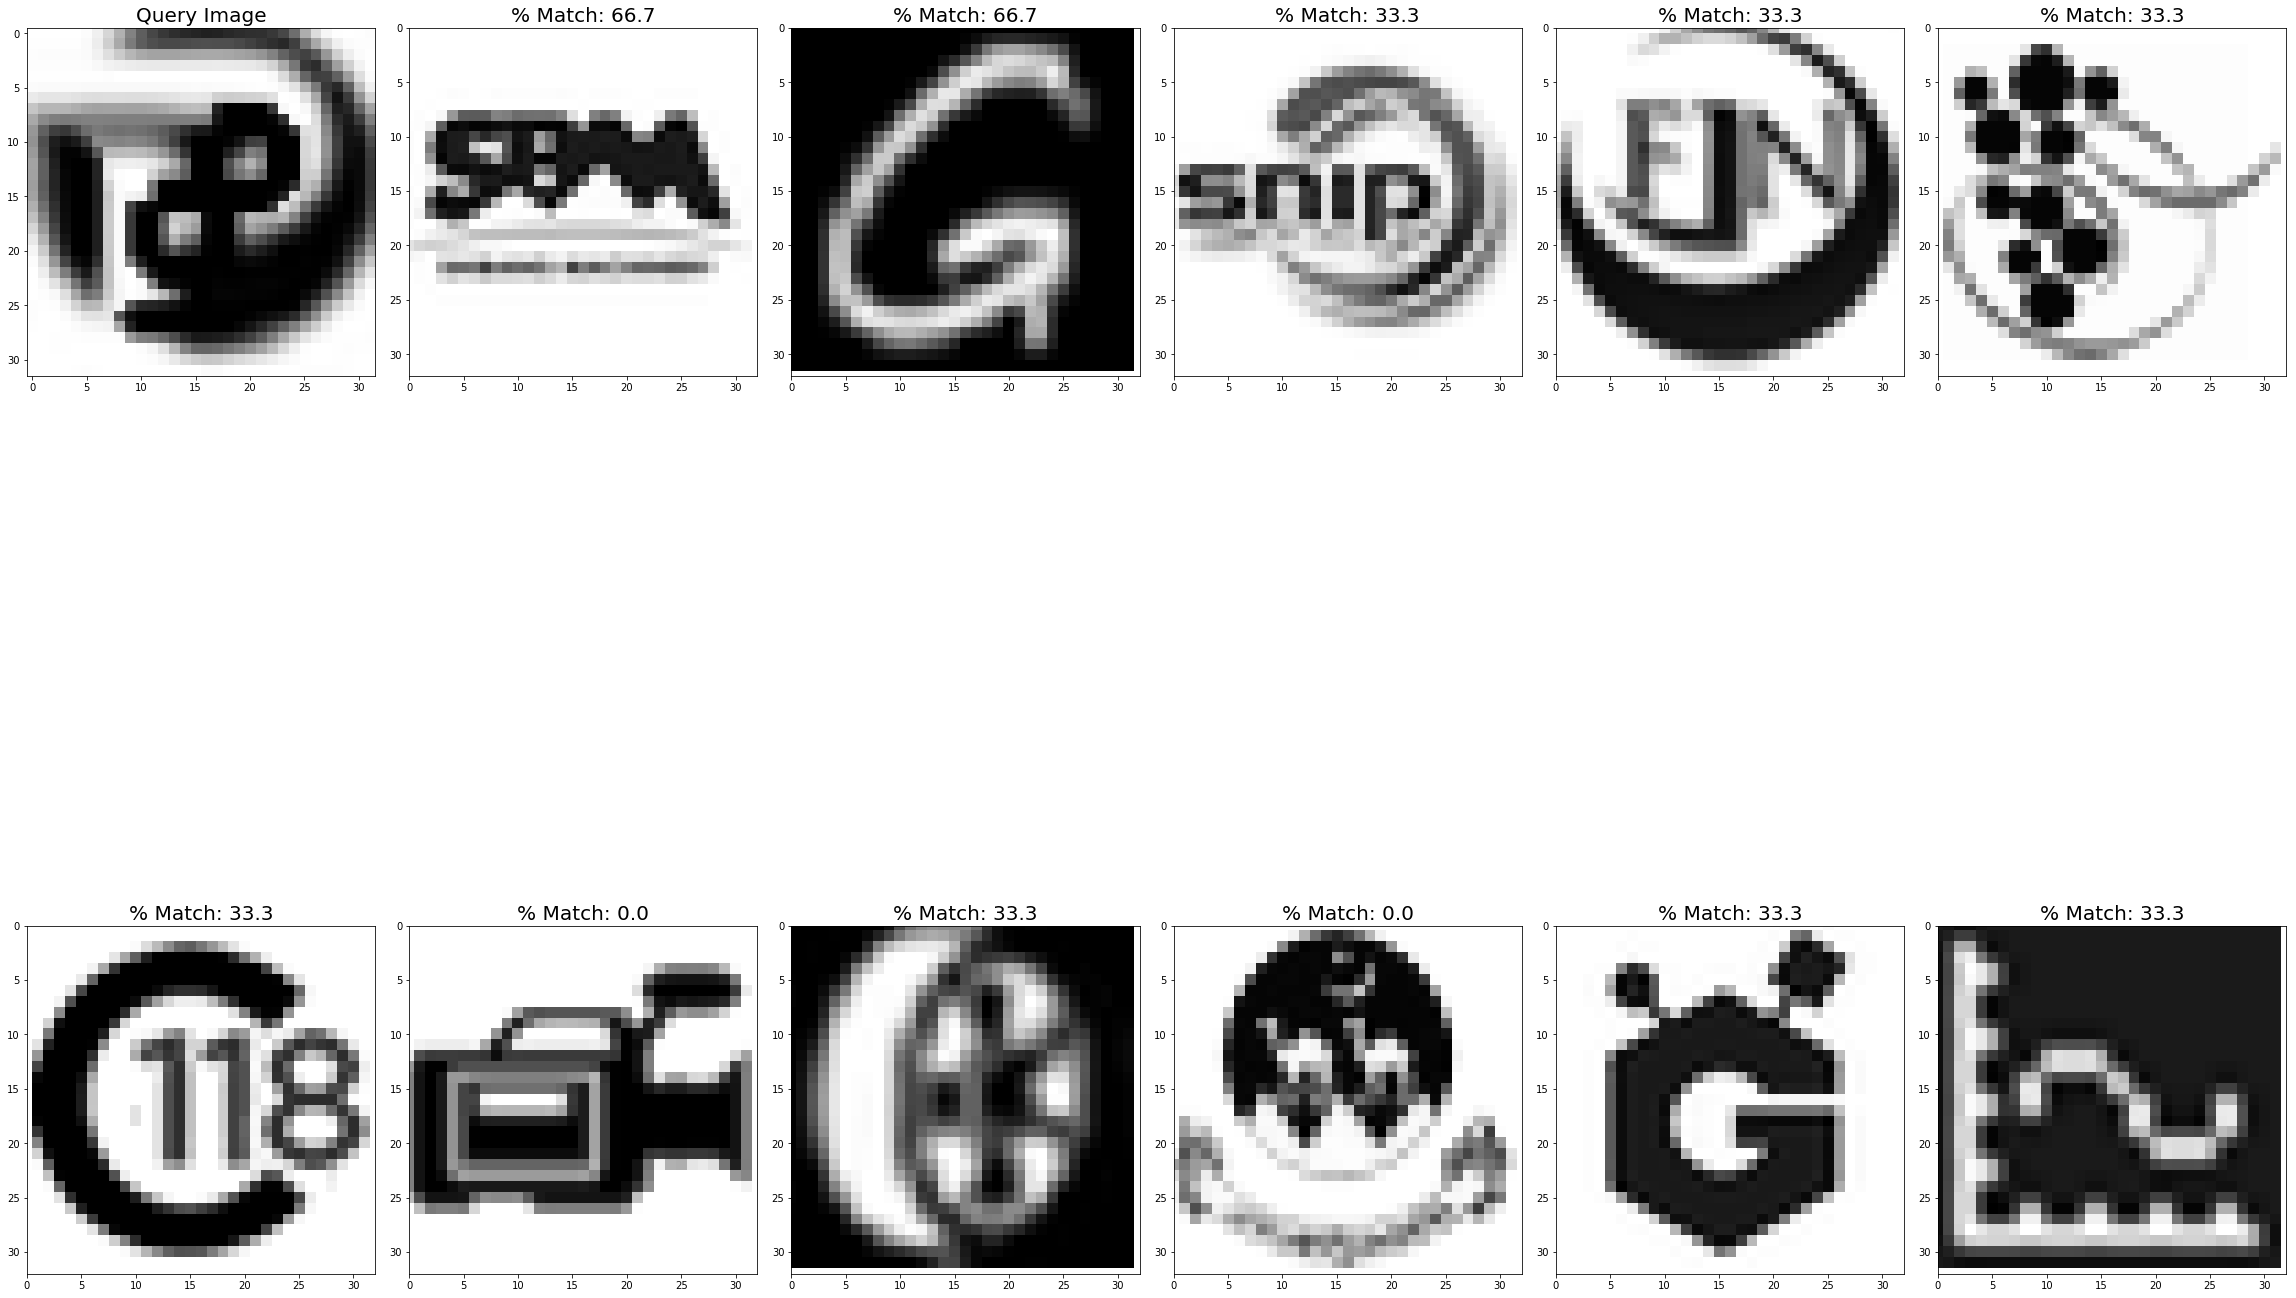

In [6]:
## plot query image and top 11 hits, just for checking purposes  
plot_results(Data, matched_list_v2)

In [12]:
## load scores from log files
success = []
contour_score = []
zernike_score = []
sift_score = []
orb_score = []
image = []
indices = []
mutation = []

# loop through image indices of existing queries 
for fname in tqdm_notebook(os.listdir('.\Logs')):
	x1 = fname.find('_')+1
	x2 = fname.find('.')
	i = int(fname[x1:x2])
	indices.append(i)

	j = 0
	#open log file of query
	with open('C:/Users/kchad/Documents/Logo Project/Logs/' + fname,"r") as myfile:
		for line in myfile:
			j += 1
			if j % 8 == 0:
				for k in range(0,result_len):
					mutation.append(line[40:])
			if j % 8 == 1:
				result_len = 0           
			#  line has the results 
			if j % 8 == 7:
				result = eval(line[13:])
				result_len = len(result)
				first_contour = result[0][1]
				first_zernike = result[0][2]
				first_sift = result[0][3]
				first_orb = result[0][4]
				
				# check if the given query result was the original image, 1 for correct, 0 for incorrect
				for elem in result:
					if elem[0] == i:
						success.append(1)
					else:
						success.append(0)
						
					# normalize the contour/zernike scores
					if first_contour > 0:                    
						contour_score.append( round(elem[1]/first_contour, 3) )
					else:
						contour_score.append(0)    
                        
					if first_zernike > 0:                         
						zernike_score.append( round(elem[2]/first_zernike, 3) )
					else:
						zernike_score.append(0)                        
					if first_sift > 0:
						sift_score.append( round(elem[3]/first_sift, 3) )
					else:
						sift_score.append(0)
                        
					if first_orb > 0:
						orb_score.append( round(elem[4]/first_orb, 3) )
					else:
						orb_score.append(0)                        

					image.append(i)
                    
input_score = np.array(list(zip(contour_score,zernike_score,sift_score,orb_score,image,success,mutation)))
input_score = pd.DataFrame(input_score,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation'])
                    

In [13]:
###### logsitic regression for weights of 4 methods
numbers = [i for i in range(100,115)]
random.shuffle(numbers)
training = numbers[0:10]
testing = numbers[10:15]

### search for a particular mutation
mutation_string = 'ab_flip'

mutation_string = mutation_string + ' at'
input_score_mutation = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(training))]
input_score_mutation = input_score_mutation.values

### create test data set, not used for training
input_score_test = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(testing) )]
input_score_test = pd.DataFrame(input_score_test,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation'])

### run logistic regression on training data
clf = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial').fit(input_score_mutation[:,(0,1,2,3)], input_score_mutation[:,5])
logistic_weights = clf.coef_[0]/sum(clf.coef_[0])
print(logistic_weights)

### use weights to calculate weighted score and rank on training set
input_score_mutation = pd.DataFrame(input_score_mutation,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation'])

input_score_mutation["contour_score"] = input_score_mutation["contour_score"].astype(float)
input_score_mutation["zernike_score"] = input_score_mutation["zernike_score"].astype(float)
input_score_mutation["sift_score"] = input_score_mutation["sift_score"].astype(float)
input_score_mutation["orb_score"] = input_score_mutation["orb_score"].astype(float)

input_score_mutation["avg_score"] = .25*input_score_mutation["contour_score"] + .25*input_score_mutation["zernike_score"] + .25*input_score_mutation["sift_score"] + .25*input_score_mutation["orb_score"]
input_score_mutation["weight_score"] = logistic_weights[0]*input_score_mutation["contour_score"] + logistic_weights[1]*input_score_mutation["zernike_score"] + logistic_weights[2]*input_score_mutation["sift_score"] + logistic_weights[3]*input_score_mutation["orb_score"]
input_score_mutation['Avg_Rank'] = input_score_mutation.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
input_score_mutation['Weight_Rank'] = input_score_mutation.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

### use weights to calculate weighted score and rank on test set
input_score_test["contour_score"] = input_score_test["contour_score"].astype(float)
input_score_test["zernike_score"] = input_score_test["zernike_score"].astype(float)
input_score_test["sift_score"] = input_score_test["sift_score"].astype(float)
input_score_test["orb_score"] = input_score_test["orb_score"].astype(float)

input_score_test["avg_score"] = .25*input_score_test["contour_score"] + .25*input_score_test["zernike_score"] + .25*input_score_test["sift_score"] + .25*input_score_test["orb_score"]
input_score_test["weight_score"] = logistic_weights[0]*input_score_test["contour_score"] + logistic_weights[1]*input_score_test["zernike_score"] + logistic_weights[2]*input_score_test["sift_score"] + logistic_weights[3]*input_score_test["orb_score"]
input_score_test['Avg_Rank'] = input_score_test.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
input_score_test['Weight_Rank'] = input_score_test.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

### check the rank of the original image, see if image was within the top 10 search results
successes = input_score_mutation[input_score_mutation["success"].astype(float) == 1]

avg_rank = sum(successes['Avg_Rank'])/successes.shape[0]
weight_rank = sum(successes['Weight_Rank'])/successes.shape[0]
top10_avg_rank = len( successes[(successes['Avg_Rank'] < 11)] )
top10_weight_rank = len( successes[(successes['Weight_Rank'] < 11)] )

print((avg_rank,weight_rank,top10_avg_rank,top10_weight_rank))

successes_t = input_score_test[input_score_test["success"].astype(float) == 1]

avg_rank_t = sum(successes_t['Avg_Rank'])/successes_t.shape[0]
weight_rank_t = sum(successes_t['Weight_Rank'])/successes_t.shape[0]
top10_avg_rank_t = len( successes_t[(successes_t['Avg_Rank'] < 11)] )
top10_weight_rank_t = len( successes_t[(successes_t['Weight_Rank'] < 11)] )

print((avg_rank_t,weight_rank_t,top10_avg_rank_t,top10_weight_rank_t))

#input_score.to_csv(path_or_buf='./score_result_2.csv', sep=',',index = False)

[0.17072422 0.44185922 0.17043928 0.21697728]
(2.6, 1.0, 9, 10)
(1.0, 1.0, 5, 5)


In [5]:
###### logsitic regression for weights of 3 methods, removing SIFT
numbers = [i for i in range(0,100)]
random.shuffle(numbers)
training = numbers[0:60]
testing = numbers[60:100]

### search for a particular mutation
mutation_string = 'ab_'

#mutation_string = mutation_string + ' at'
input_score_mutation = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(training))]
input_score_mutation = input_score_mutation.values

### create test data set, not used for training
input_score_test = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(testing) )]
input_score_test = pd.DataFrame(input_score_test,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation'])

### run logistic regression on training data
clf = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial').fit(input_score_mutation[:,(0,1,3)], input_score_mutation[:,5])
logistic_weights = clf.coef_[0]/sum(clf.coef_[0])
print(logistic_weights)

### use weights to calculate weighted score and rank on training set
input_score_mutation = pd.DataFrame(input_score_mutation,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation'])

input_score_mutation["contour_score"] = input_score_mutation["contour_score"].astype(float)
input_score_mutation["zernike_score"] = input_score_mutation["zernike_score"].astype(float)
input_score_mutation["sift_score"] = input_score_mutation["sift_score"].astype(float)
input_score_mutation["orb_score"] = input_score_mutation["orb_score"].astype(float)

input_score_mutation["avg_score"] = .3333*input_score_mutation["contour_score"] + .3333*input_score_mutation["zernike_score"] + .0*input_score_mutation["sift_score"] + .3333*input_score_mutation["orb_score"]
input_score_mutation["weight_score"] = logistic_weights[0]*input_score_mutation["contour_score"] + logistic_weights[1]*input_score_mutation["zernike_score"] + 0*input_score_mutation["sift_score"] + logistic_weights[2]*input_score_mutation["orb_score"]
input_score_mutation['Avg_Rank'] = input_score_mutation.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
input_score_mutation['Weight_Rank'] = input_score_mutation.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

### use weights to calculate weighted score and rank on test set
input_score_test["contour_score"] = input_score_test["contour_score"].astype(float)
input_score_test["zernike_score"] = input_score_test["zernike_score"].astype(float)
input_score_test["sift_score"] = input_score_test["sift_score"].astype(float)
input_score_test["orb_score"] = input_score_test["orb_score"].astype(float)

input_score_test["avg_score"] = .3333*input_score_test["contour_score"] + .3333*input_score_test["zernike_score"] + .0*input_score_test["sift_score"] + .3333*input_score_test["orb_score"]
input_score_test["weight_score"] = logistic_weights[0]*input_score_test["contour_score"] + logistic_weights[1]*input_score_test["zernike_score"] + 0*input_score_test["sift_score"] + logistic_weights[2]*input_score_test["orb_score"]
input_score_test['Avg_Rank'] = input_score_test.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
input_score_test['Weight_Rank'] = input_score_test.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

### check the rank of the original image, see if image was within the top 10 search results
successes = input_score_mutation[input_score_mutation["success"].astype(float) == 1]

avg_rank = sum(successes['Avg_Rank'])/successes.shape[0]
weight_rank = sum(successes['Weight_Rank'])/successes.shape[0]
top10_avg_rank = len( successes[(successes['Avg_Rank'] < 11)] )
top10_weight_rank = len( successes[(successes['Weight_Rank'] < 11)] )

print((avg_rank,weight_rank,top10_avg_rank,top10_weight_rank))

successes_t = input_score_test[input_score_test["success"].astype(float) == 1]

avg_rank_t = sum(successes_t['Avg_Rank'])/successes_t.shape[0]
weight_rank_t = sum(successes_t['Weight_Rank'])/successes_t.shape[0]
top10_avg_rank_t = len( successes_t[(successes_t['Avg_Rank'] < 11)] )
top10_weight_rank_t = len( successes_t[(successes_t['Weight_Rank'] < 11)] )

print((avg_rank_t,weight_rank_t,top10_avg_rank_t,top10_weight_rank_t))

#input_score.to_csv(path_or_buf='./score_result_2.csv', sep=',',index = False)

[0.13248331 0.02651655 0.84100015]
(1974.1943359375, 2480.30078125, 111, 122)
(2216.609144542773, 2391.7374631268435, 69, 83)


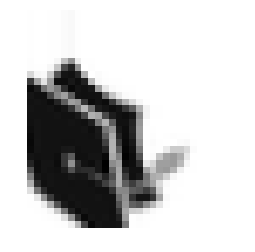

In [41]:
### display an image
image_index = 50
Data = gray(images[image_index])
Data, mutation = ab_random(Data, n = 9)

imgplot = plt.imshow(Data, cmap=plt.cm.gray)
plt.axis('off')
plt.show()